# INFO-F-424 - Combinatorial optimization - 2023-2024

### Arfani Salah-Eddine - salah-eddine.arfani@ulb.be - 000495528

### El Mokhtari Younes - younes.el.mokhtari@ulb.be - 000479836

### Jeq Ismail - ismail.jeq@ulb.be - 000494718

## Assortment Planning Problem (AP)

In [95]:
!pip3 install gurobipy

Defaulting to user installation because normal site-packages is not writeable


In [96]:
# Import libraries
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from math import exp
from decimal import Decimal
import os
import json

In [97]:
# load data
medium_mu = pd.read_csv('data/medium-mu.csv', sep=';', header=None, dtype=float)
medium_r = pd.read_csv('data/medium-r.csv', sep=';', header=None, dtype=float)
small_mu = pd.read_csv('data/small-mu.csv', sep=';', header=None, dtype=float)
small_r = pd.read_csv('data/small-r.csv', sep=';', header=None, dtype=float)


In [98]:
import numpy as np
import pandas as pd

def generate_parameters(n):
    mu = np.random.uniform(0, 1, size = n + 1)
    mu[0] = 0
    r = np.random.uniform(0, 1, size = n + 1)
    r[0] = 0
    return mu, r

def create_large_instances(m, n):
    mu_file = 'data/large-mu.csv'
    r_file = 'data/large-r.csv'
    mu_data = []
    r_data = []

    for i in range(m):
        mu, r = generate_parameters(n)
        mu_data.append(mu)
        r_data.append(r)
        
    # Takes too long to save the data
    # mu_data = np.array(mu_data).T
    # r_data = np.array(r_data).T

    # f_mu_data = np.vectorize(lambda x: f"{x:.18e}")(mu_data)
    # f_r_data = np.vectorize(lambda x: f"{x:.18e}")(r_data)

    # mu_df = pd.DataFrame(f_mu_data)
    # r_df = pd.DataFrame(f_r_data)

    # mu_df.to_csv(mu_file, index=False, header=None, sep=';')
    # r_df.to_csv(r_file, index=False, header=None, sep=';')

    return mu_data, r_data

In [99]:
# Create instance
def create_instances(data):
    list_instances = []
    for j in range(0, data.shape[1]):
        list_instances.append(data.iloc[:,j].to_list())

    return list_instances
instances_small_mu = create_instances(small_mu)
instances_small_r = create_instances(small_r)
instances_medium_mu = create_instances(medium_mu)
instances_medium_r = create_instances(medium_r)

large_mu, large_r = create_large_instances(100, 1000000)

### 0. Introduction

In this project, we focus on the Assortment Planning Problem (AP), where a retailer wants to determine which products it has to propose to its customers in order to maximize its expected revenue. More precisely, consider a set of products $\mathcal{I}=\{1, \ldots, n\}$ that the retailer can propose to its customers, and selling product $i$ generates a net revenue of $r_{i}>0$ for him. We assume that the products are sorted in decreasing order of revenue, i.e. $r_{1}>r_{2}>\cdots>r_{n}>0$, and that each product $i$ will be purchased according to a particular probability that depends on:

- The mean utilities $\left(\mu_{j}\right)_{j \in \mathcal{I}}$ for the customers when they buy product $j \in \mathcal{I}$,

- The set of alternatives $\mathcal{S}$ made available to the customers.

These probabilities come from a discrete choice model called multinomial logit, and can be written as follows:

$$
P_{i}(\mathcal{S})=\frac{e^{\mu_{i}}}{e^{\mu_{0}}+\sum_{j \in \mathcal{S}} e^{\mu_{j}}}=\frac{e^{\mu_{i}}}{1+\sum_{j \in \mathcal{S}} e^{\mu_{j}}}, \quad \forall i \in \mathcal{I} \cup\{0\}
$$

where $\mu_{0}=0$ represents the utility - for the customers - of buying nothing. As we will see later on, it is convenient to assume that selling nothing does come with a revenue $r_{0} \geqslant 0$ (that is, however, usually zero). With all of the above, the problem can be posed as the following combinatorial optimization problem:

$$
\text { (AP) } \max _{\mathcal{S} \subseteq \mathcal{I}}\left\{r_{0} \cdot P_{0}(\mathcal{S})+\sum_{i \in \mathcal{S}} r_{i} \cdot P_{i}(\mathcal{S})\right\}
$$

### 1. From combinatorial optimization to linear programming

#### 1.1 Show that AP can be rewritten as the following integer programming problem:

$$
\text { (AP-IP) } \max _{x \in\{0,1\}^{n}} \frac{r_{0}+\sum_{i=1}^{n} x_{i} r_{i} e^{\mu_{i}}}{1+\sum_{i=1}^{n} x_{i} e^{\mu_{i}}}
$$

#### Explain why this formulation is valid for the Assortment Planning Problem (variables, constraints, objective function), and why this formulation is nonlinear.

We can convert (AP) into an integer programming problem (AP-IP) by introducing binary decision variables $x_i$, where $x_i = 1$ if product $i$ is included in the assortment $\mathcal{S}$, and $x_i = 0$ otherwise. We can rewrite the probabilities and revenues using $x_i$. For the no-purchase option, we have:

$$
P_0(\mathcal{S}) = \frac{1}{1 + \sum_{i=1}^n x_i e^{\mu_i}}
$$

For purchasing product $i$, we have:

$$
P_i(\mathcal{S}) = \frac{x_i e^{\mu_i}}{1 + \sum_{i=1}^n x_i e^{\mu_i}}
$$

If we take the objective function of AP:

$$
r_0 \cdot P_0(\mathcal{S}) + \sum_{i \in \mathcal{S}} r_i \cdot P_i(\mathcal{S})
$$

By replacing, we obtain:

$$
\frac{r_0 + \sum_{i=1}^n x_i r_i e^{\mu_i}}{1 + \sum_{i=1}^n x_i e^{\mu_i}}
$$

This forms the objective function of (AP-IP):

$$
\text { (AP-IP) } \max _{x \in\{0,1\}^{n}} \frac{r_{0}+\sum_{i=1}^{n} x_{i} r_{i} e^{\mu_{i}}}{1+\sum_{i=1}^{n} x_{i} e^{\mu_{i}}}
$$

This formulation is valid because the binary decision variables $x_i$ indicate whether each product is included in the assortment, the constraints ensure these variables remain binary and the objective function maximizes the revenue based on the probability and the selected products. Since the denominator of the objective function is a polynomial, the formulation is nonlinear.

#### 1.2 Considering the following change of variables:


$$
\begin{aligned}
y_{0} & :=\frac{1}{1+\sum_{j=1}^{n} x_{j} e^{\mu_{j}}} \\
y_{i} & :=\frac{x_{i} e^{\mu_{i}}}{1+\sum_{j=1}^{n} x_{j} e^{\mu_{j}}}, \quad \forall i \in \mathcal{I}
\end{aligned}
$$

#### prove that AP-IP can be rewritten as the following problem:

$$
\begin{aligned}
\text { (AP-IPL) } \max _{y, y_{0} \geqslant 0} & r_{0} y_{0}+\sum_{i=1}^{n} r_{i} y_{i} \\
\text { s.t. } & y_{0}+\sum_{i=1}^{n} y_{i}=1 \\
& y_{i} \in\left\{0, y_{0} e^{\mu_{i}}\right\},
\end{aligned} \quad \forall i \in \mathcal{I}
$$

#### where $y_{i} \in\left\{0, y_{0} e^{\mu_{i}}\right\}$ means that $y_{i}$ must take either 0 or $y_{0} e^{\mu_{i}}$ as a value.

Let's decompose the objective function of (AP-IP), we have:

$$
\frac{r_0}{1 + \sum_{j=1}^n x_j e^{\mu_j}} + \frac{\sum_{j=1}^n x_j r_i e^{\mu_j}}{1 + \sum_{j=1}^n x_j e^{\mu_j}}
$$

Using the change of variables, we immediately obtain the objective function of (AP-IPL):

$$
\quad r_{0} y_{0} + \sum_{i=1}^{n} r_{i} y_{i}
$$

Let's find the constraints now. Using the change of variables, we have:
$$
y_0 + \sum_{i=1}^n y_i = \frac{1}{1+\sum_{j=1}^{n} x_{j} e^{\mu_{j}}} + \sum_{i=1}^{n} \frac{x_{i} e^{\mu_{i}}}{1+\sum_{j=1}^{n} x_{j} e^{\mu_{j}}} = \frac{1 + \sum_{i=1}^{n} x_{i} e^{\mu_{i}}}{1 + \sum_{j=1}^{n} x_{j} e^{\mu_{j}}} = 1
$$

This gives us the first constraint:
$$
y_0 + \sum_{i=1}^n y_i = 1
$$

Next, we consider the values $y_i$ can take. From the definition:
$$
y_i = \frac{x_i e^{\mu_i}}{1+\sum_{j=1}^n x_j e^{\mu_j}}
$$

When $x_i = 0$, we have:
$$
y_i = 0
$$

When $x_i = 1$, we have:
$$
y_i = \frac{e^{\mu_i}}{1+\sum_{j=1}^n x_j e^{\mu_j}} = y_0 e^{\mu_i}
$$

This implies:
$$
y_i \in \{0, y_0 e^{\mu_i}\}, \quad \forall i \in \mathcal{I}
$$

Finally, the AP-IP problem can be rewritten as AP-IPL:
$$
\begin{aligned}
\text { (AP-IPL) } \max _{y, y_{0} \geqslant 0} & r_{0} y_{0}+\sum_{i=1}^{n} r_{i} y_{i} \\
\text { s.t. } & y_{0}+\sum_{i=1}^{n} y_{i}=1 \\
& y_{i} \in\left\{0, y_{0} e^{\mu_{i}}\right\}, \quad \forall i \in \mathcal{I}
\end{aligned}
$$

#### 1.3 Consider the continuous relaxation of AP-IPL:

$$
\begin{array}{rlr}
\text{(AP-L)} \quad \max_{y, y_{0} \geqslant 0} & r_{0} y_{0} + \sum_{i=1}^{n} r_{i} y_{i} & \\
\text{s.t.} & y_{0} + \sum_{i=1}^{n} y_{i} = 1 & \\
& y_{i} \leqslant y_{0} e^{\mu_{i}} & \forall i \in \mathcal{I}
\end{array}
$$

#### Prove that its linear programming dual is:

$$
\begin{array}{rl}
\text{(AP-LD)} \quad \min_{\pi \geqslant 0, \pi_{0} \in \mathbb{R}} & \pi_{0} \\
\text{s.t.} & \pi_{0} - \sum_{i=1}^{n} \pi_{i} e^{\mu_{i}} \geqslant r_{0} \\
& \pi_{0} + \pi_{i} \geqslant r_{i} \quad \forall i \in \mathcal{I}
\end{array}
$$

#### and explain the relationships between dual (resp. primal) variables and primal (resp. dual) constraints.


We will use the duality theorem to find (AP-LD). Let's reformulate the primal first, we have:

$$
\begin{array}{rlr}
\max_{y, y_{0} \geqslant 0} & r_{0} y_{0} + \sum_{i=1}^{n} r_{i} y_{i} & \\
\text{s.t.} & y_{0} + \sum_{i=1}^{n} y_{i} = 1 & \\
& - y_{0} e^{\mu_{i}} + y_{i} \leqslant 0 & \forall i \in \mathcal{I}
\end{array}
$$

To formulate the dual problem, we associate dual variables with each constraint of the primal problem. Let's denote the dual variables as follows:

- $\pi_0$ for the first constraint $y_0 + \sum_{i=1}^n y_i = 1$.
- $\pi_i$ for the second constraint $- y_{0} e^{\mu_{i}} + y_{i} \leqslant 0 $.

The dual objective function is derived from the constant term in the constraints multiplied by the dual variables. So, we obtain:

$$
\min_{\pi_0, \pi_i} \quad \pi_0
$$


The dual constraints can be derived from the coefficients of the primal constraints and the primal objective function, we have:

$$
\begin{array}{rl}
\pi_0 - \sum_{i=1}^{n} \pi_i e^{\mu_i} \geq r_0 \\
\pi_0 + \pi_i \geq r_i
\end{array} \quad \forall i \in \mathcal{I}
$$

Thus, the dual problem (AP-LD) is:

$$
\begin{array}{rl}
\min_{\pi \geqslant 0, \pi_{0} \in \mathbb{R}} & \pi_{0} \\
\text{s.t.} & \pi_{0} - \sum_{i=1}^{n} \pi_{i} e^{\mu_{i}} \geqslant r_{0} \\
& \pi_{0} + \pi_{i} \geqslant r_{i} \quad \forall i \in \mathcal{I}
\end{array}
$$


In the primal, we had:

- $y_0$ which represents the probability of a customer of buying nothing given the set of products in the assortment.
- $y_i$ which represents the probability of a customer of buying product $i$ given the set of products in the assortment.

Now in the dual, we have:

- $\pi_0$ which is associated with the first primal constraint $y_0 + \sum_{i=1}^n y_i = 1$. It measures the importance of ensuring that the total probability of all choices adds up to 100%. 

- $\pi_i$ which is associated with the second primal constraint $- y_0 e^{\mu_i} + y_i \leq 0$ for each product $i \in \mathcal{I}$. It measures the importance of ensuring that the probability of choosing product $i$ fits within its attractiveness limit.

### 2. Ideal formulation and a greedy algorithm

We now show that, with the help of AP-L, we can solve AP in polynomial time.

#### 2.1 For any $k \in \mathcal{I}$, consider the following solution:


$$
\begin{aligned}
y_{0}^{k} & :=\frac{1}{1+\sum_{j=1}^{k} e^{\mu_{j}}} \\
y_{i}^{k} & :=\left\{\begin{array}{ll}
\frac{e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} & \text { if } i \leqslant k \\
0 & \text { otherwise. }
\end{array} \quad \forall i \in \mathcal{I} .\right.
\end{aligned}
$$

##### 2.1.1 Show that $\left(y^{k}, y_{0}^{k}\right)$ is feasible for AP-L. What is its objective value?

To show that $\left(y^{k}, y_{0}^{k}\right)$ is feasible for AP-L, we need to check that it satisfies the constraints of AP-L. For the constraint 1, we have:

$$
y_{0}^{k} + \sum_{i=1}^{k} y_{i}^{k} = \frac{1}{1+\sum_{j=1}^{k} e^{\mu_{j}}} + \frac{\sum_{i=1}^{k} e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} = \frac{1 + \sum_{i=1}^{k} e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} = 1
$$

Therefore, the first constraint is satisfied. For the second constraint, we have:

For $ i \leqslant k $:

$$
y_{i}^{k} = \frac{e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} \quad \text{and} \quad y_{0}^{k} e^{\mu_{i}} = \frac{e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}}
$$

So,

$$
y_{i}^{k} = y_{0}^{k} e^{\mu_{i}}
$$

For $ i > k $:

$$
y_{i}^{k} = 0 \quad \text{and} \quad y_{0}^{k} e^{\mu_{i}} = \frac{e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} > 0
$$

Thus,

$$
y_{i}^{k} \leqslant y_{0}^{k} e^{\mu_{i}}
$$

Therefore, the second constraint is satisfied.

Since both constraints are satisfied, $\left(y^{k}, y_{0}^{k}\right)$ is feasible for AP-L. Let's compute now the objective value for $\left(y^{k}, y_{0}^{k}\right)$:

$$
r_{0} y_{0}^{k} + \sum_{i=1}^{n} r_{i} y_{i}^{k}
$$

We develop $y_0$ and $y_{0}^{k}$:

$$
\frac{r_{0}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} + \sum_{i=1}^{k} \frac{r_{i} e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}}
$$

After factoring, the objective value is:

$$
\frac{r_{0} + \sum_{i=1}^{k} r_{i} e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}}
$$

##### 2.1.2 Using the change of variables in (1.2), prove that the associated $x^{k}$ is integer.

To prove that the associated $x^{k}$ is integer, we use the change of variables defined in (1.2):

$$
\begin{aligned}
y_{0} & := \frac{1}{1+\sum_{j=1}^{n} x_{j} e^{\mu_{j}}} \\
y_{i} & := \frac{x_{i} e^{\mu_{i}}}{1+\sum_{j=1}^{n} x_{j} e^{\mu_{j}}}, \quad \forall i \in \mathcal{I}
\end{aligned}
$$

Given:

$$
y_{0}^{k} = \frac{1}{1+\sum_{j=1}^{k} e^{\mu_{j}}}
$$

and

$$
y_{i}^{k} = \left\{
\begin{array}{ll}
\frac{e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} & \text{if } i \leqslant k \\
0 & \text{otherwise.}
\end{array} \right.
$$

We want to show that the associated $x^{k}$ is integer. From the change of variables, we have:

$$
x_{i} = \frac{y_{i} (1+\sum_{j=1}^{n} x_{j} e^{\mu_{j}})}{e^{\mu_{i}}}
$$

For $i \leq k$:

$$
x_{i}^{k} = \frac{y_{i}^{k} (1+\sum_{j=1}^{k} e^{\mu_{j}})}{e^{\mu_{i}}}
    = \frac{\frac{e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} (1+\sum_{j=1}^{k} e^{\mu_{j}})}{e^{\mu_{i}}} 
    = \frac{e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} \cdot \frac{1+\sum_{j=1}^{k} e^{\mu_{j}}}{e^{\mu_{i}}}
    = \frac{e^{\mu_{i}}}{e^{\mu_{i}}}
    = 1
$$

For $i > k$:

$$
y_{i}^{k} = 0 \implies x_{i}^{k} = \frac{0 \cdot (1+\sum_{j=1}^{k} e^{\mu_{j}})}{e^{\mu_{i}}} = 0
$$

Therefore, the associated $x^{k}$ is integer, where:

$$
x_{i}^{k} = \left\{
\begin{array}{ll}
1 & \text{if } i \leq k \\
0 & \text{if } i > k
\end{array} \right.
$$


##### 2.1.3 Show that $\left(y^{k}, y_{0}^{k}\right)$ is a strictly better solution than $\left(y^{k-1}, y_{0}^{k-1}\right)$ if and only if:

$$
r_{k}>\frac{r_{0}+\sum_{j=1}^{k-1} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k-1} e^{\mu_{j}}}
$$

To show this, we need to compare the objective values of $\left(y^{k}, y_{0}^{k}\right)$ and $\left(y^{k-1}, y_{0}^{k-1}\right)$.

The objective value for $\left(y^{k}, y_{0}^{k}\right)$ is:

$$
\frac{r_{0} + \sum_{i=1}^{k} e^{\mu_{i}} r_{i}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}}
$$

The objective value for $\left(y^{k-1}, y_{0}^{k-1}\right)$ is:

$$
\frac{r_{0} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}}
$$

We need to show that:

$$
\frac{r_{0} + \sum_{i=1}^{k} e^{\mu_{i}} r_{i}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}} > \frac{r_{0} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}}
$$

We can cross-multiply to compare the numerators directly:

$$
(r_{0} + \sum_{i=1}^{k} e^{\mu_{i}} r_{i})(1 + \sum_{j=1}^{k-1} e^{\mu_{j}}) > (r_{0} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i})(1 + \sum_{j=1}^{k} e^{\mu_{j}})
$$

$$
\iff
$$

$$
r_{0} + r_{0} \sum_{j=1}^{k-1} e^{\mu_{j}} + \sum_{i=1}^{k} e^{\mu_{i}} r_{i} + \sum_{i=1}^{k} e^{\mu_{i}} r_{i} \sum_{j=1}^{k-1} e^{\mu_{j}} > r_{0} + r_{0} \sum_{j=1}^{k} e^{\mu_{j}} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i} \sum_{j=1}^{k} e^{\mu_{j}}
$$

We cancel out the common terms:

$$
r_{0} \sum_{j=1}^{k-1} e^{\mu_{j}} + \sum_{i=1}^{k} e^{\mu_{i}} r_{i} + \sum_{i=1}^{k} e^{\mu_{i}} r_{i} \sum_{j=1}^{k-1} e^{\mu_{j}} > r_{0} \sum_{j=1}^{k} e^{\mu_{j}} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i} \sum_{j=1}^{k} e^{\mu_{j}}
$$

$$
\iff
$$

$$
e^{\mu_{k}} r_{k} + e^{\mu_{k}} r_{k} \sum_{j=1}^{k-1} e^{\mu_{j}} > r_{0} e^{\mu_{k}} + e^{\mu_{k}} \sum_{i=1}^{k-1} e^{\mu_{j}} r_{i}
$$

$$
\iff
$$

$$
r_{k} + r_{k} \sum_{j=1}^{k-1} e^{\mu_{j}} > r_{0} + \sum_{i=1}^{k-1} e^{\mu_{j}} r_{i}
$$


We can factor out $r_{k}$:

$$
r_{k} (1 + \sum_{j=1}^{k-1} e^{\mu_{j}}) > r_{0} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i}
$$

We divide both sides by $1 + \sum_{j=1}^{k-1} e^{\mu_{j}}$:

$$
r_{k} > \frac{r_{0} + \sum_{i=1}^{k-1} e^{\mu_{i}} r_{i}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}}
$$

Thus, $\left(y^{k}, y_{0}^{k}\right)$ is a strictly better solution than $\left(y^{k-1}, y_{0}^{k}\right)$ if and only if:

$$
r_{k} > \frac{r_{0} + \sum_{j=1}^{k-1} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}}
$$

##### 2.1.4 Prove that there is no $k \in \mathcal{I}$ such that

$$
r_{k} \leqslant \frac{r_{0}+\sum_{j=1}^{k-1} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k-1} e^{\mu_{j}}} \quad \text { and } \quad r_{k+1}>\frac{r_{0}+\sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k} e^{\mu_{j}}}
$$

##### at the same time. What does the graph of the function $k \rightarrow r^{\top} y^{k}$ look like?

To prove that both conditions cannot hold simultaneously, let's assume they do and show a contradiction.

Suppose there exists a $k \in \mathcal{I}$ such that:

1. $r_{k} \leq \frac{r_{0} + \sum_{j=1}^{k-1} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}}$
2. $r_{k+1} > \frac{r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}}$

Let's denote these values as follows:

- $A = \frac{r_{0} + \sum_{j=1}^{k-1} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}}$
- $B = \frac{r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}}$

So we have:

$$
r_{k} \leq A \quad \text{and} \quad r_{k+1} > B
$$

Let's compare $B$ and $A$. We can rewrite $B$ as:

$$
B = \frac{r_{0} + \sum_{j=1}^{k-1} e^{\mu_{j}} r_{j} + e^{\mu_{k}} r_{k}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}} + e^{\mu_{k}}}
$$

By introducing $A$, we can rewrite $B$ in terms of $A$:

$$
B = \frac{A \cdot (1 + \sum_{j=1}^{k-1} e^{\mu_{j}}) + e^{\mu_{k}} r_{k}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}} + e^{\mu_{k}}}
$$

Since $r_k \leq A$, we can replace $r_k$ with $A$ and we obtain that:

$$
B \leq A
$$

This implies that $r_{k+1}$ cannot be greater than $B$ if $r_k \leq A$ because it will mean that $r_{k+1} > r_k$, which is not possible based on our initial assumption of the problem.

Therefore, it is impossible for both conditions to hold at the same time.

The graph of the function $k \rightarrow r^{\top} y^{k}$ would show a non-increasing function because as more products are included in the assortment, the expected revenue for k products will tend to decrease or stay constant.

##### 2.1.5 Deduce that there is exactly one $k^{*} \in \mathcal{I}$ such that

$$
r_{1}>\cdots>r_{k^{*}}>\frac{r_{0}+\sum_{j=1}^{k^{*}-1} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k^{*}-1} e^{\mu_{j}}} \quad \text { and } \quad \frac{r_{0}+\sum_{j=1}^{k^{*}} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k^{*}} e^{\mu_{j}}} \geqslant r_{k^{*}+1}>\cdots>r_{n}
$$

From 2.1.3, we showed that $y^{k}$ is a better solution than $y^{k-1}$ if and only if

$$
r_{k} > \frac{r_{0} + \sum_{j=1}^{k-1} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}}
$$

From 2.1.4, we proved that there is no $k$ such that

$$
r_{k} \leq \frac{r_{0} + \sum_{j=1}^{k-1} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k-1} e^{\mu_{j}}} \quad \text{and} \quad r_{k+1} > \frac{r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}}
$$

Based on these results, there is exactly one $k^{*}$ such that:

$$
r_{1} > \cdots > r_{k^{*}} > \frac{r_{0} + \sum_{j=1}^{k^{*}-1} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k^{*}-1} e^{\mu_{j}}} \quad \text{and} \quad \frac{r_{0} + \sum_{j=1}^{k^{*}} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k^{*}} e^{\mu_{j}}} \geq r_{k^{*}+1} > \cdots > r_{n}
$$

##### 2.1.6 Show that we cannot have $r_{k^{*}}<\frac{r_{0}+\sum_{j=1}^{k^{*}} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k *} e^{\mu_{j}}}$, and deduce that we have

$$
r_{1}>\cdots>r_{k^{*}} \geqslant \frac{r_{0}+\sum_{j=1}^{k^{*}} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k^{*}} e^{\mu_{j}}} \geqslant r_{k^{*}+1}>\cdots>r_{n}
$$

From 2.1.5, we have:

$$
r_{1} > \cdots > r_{k^{*}} > \frac{r_{0} + \sum_{j=1}^{k^{*}-1} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k^{*}-1} e^{\mu_{j}}}
$$

If $ r_{k^{*}} < \frac{r_{0} + \sum_{j=1}^{k^{*}} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k^{*}} e^{\mu_{j}}} $, it would contradict our assumption since including product $ k^{*} $ should not diminish the value.

Therefore, we must have:

$$
r_{k^{*}} \geq \frac{r_{0} + \sum_{j=1}^{k^{*}} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k^{*}} e^{\mu_{j}}}
$$

Hence, we deduce:

$$
r_{1} > \cdots > r_{k^{*}} \geq \frac{r_{0} + \sum_{j=1}^{k^{*}} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k^{*}} e^{\mu_{j}}} \geq r_{k^{*}+1} > \cdots > r_{n}
$$


#### 2.2 For any $k \in \mathcal{I}$, consider the following solution:

$$
\begin{aligned}
\pi_{0}^{k} & :=\frac{r_{0}+\sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} \\
\pi_{i}^{k} & :=\left\{\begin{array}{ll}
r_{i}-\frac{r_{0}+\sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1+\sum_{j=1}^{k} e^{\mu_{j}}} & \text { if } i \leqslant k \\
0 & \text { otherwise. }
\end{array}, \quad \forall i \in \mathcal{I} .\right.
\end{aligned}
$$

##### 2.2.1 What is its objective value? In which conditions is $\left(\pi^{k}, \pi_{0}^{k}\right)$ feasible for AP-LD? Is there such a $k$ ?

The objective value of the dual problem (AP-LD) is $\pi_{0}$. Thus, for this solution, the objective value is:

$$
\pi_{0}^{k} = \frac{r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}}
$$


To determine in which conditions $\left(\pi^{k}, \pi_{0}^{k}\right)$ is feasible for AP-LD, we need to check the constraints:

1. $\pi_{0} - \sum_{i=1}^{n} \pi_{i} e^{\mu_{i}} \geq r_{0}$
2. $\pi_{0} + \pi_{i} \geq r_{i} \quad \forall i \in \mathcal{I}$

For the first constraint, we have for $i \leq k$:

$$
\pi_{0}^{k} - \sum_{i=1}^{k} \left(r_{i} - \pi_{0}^{k}\right) e^{\mu_{i}} \geq r_{0}
$$

$$
\iff
$$

$$
\pi_{0}^{k} - \sum_{i=1}^{k} r_{i} e^{\mu_{i}} + \pi_{0}^{k} \sum_{i=1}^{k} e^{\mu_{i}} \geq r_{0}
$$

$$
\iff
$$

$$
\pi_{0}^{k} \left(1 + \sum_{i=1}^{k} e^{\mu_{i}}\right) - \sum_{i=1}^{k} r_{i} e^{\mu_{i}} \geq r_{0}
$$

$$
\iff
$$

$$
\left(\frac{r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}}\right) \left(1 + \sum_{i=1}^{k} e^{\mu_{i}}\right) - \sum_{i=1}^{k} r_{i} e^{\mu_{i}} \geq r_{0}
$$

$$
\iff
$$

$$
r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j} - \sum_{i=1}^{k} r_{i} e^{\mu_{i}} \geq r_{0}
$$

This is always true as the terms cancel out. For $i > k$, we have:

$$
\pi_{0}^{k} \geq r_{0}
$$

$$
\iff
$$

$$
\frac{r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}} \geq r_{0}
$$

$$
\iff
$$

$$
r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j} \geq r_{0} \left(1 + \sum_{j=1}^{k} e^{\mu_{j}}\right)
$$

$$
\iff
$$

$$
r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j} \geq r_{0} + r_{0} \sum_{j=1}^{k} e^{\mu_{j}}
$$

$$
\iff
$$

$$
\sum_{j=1}^{k} e^{\mu_{j}} r_{j} \geq r_{0} \sum_{j=1}^{k} e^{\mu_{j}}
$$

$$
\iff
$$

$$
\sum_{j=1}^{k} e^{\mu_{j}} (r_{j} - r_{0}) \geq 0
$$

Since $r_{j} > r_{0}$ for all $j \in \mathcal{I}$, this inequality is always satisfied.

For the second constraint, for $i \leq k$, we have:

$$
\pi_{0}^{k} + \pi_{i}^{k} \geq r_{i}
$$

$$
\iff
$$

$$
\pi_{0}^{k} + \left(r_{i} - \pi_{0}^{k}\right) \geq r_{i}
$$

$$
\iff
$$

$$
r_{i} \geq r_{i}
$$



This is always true.

For $i > k$:

$$
\pi_{0}^{k} \geq r_{i}
$$

$$
\iff
$$

$$
\frac{r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j}}{1 + \sum_{j=1}^{k} e^{\mu_{j}}} \geq r_{i}
$$

$$
\iff
$$

$$
r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j} \geq r_{i} \left(1 + \sum_{j=1}^{k} e^{\mu_{j}}\right)
$$

$$
\iff
$$

$$
r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} r_{j} - r_{i} \sum_{j=1}^{k} e^{\mu_{j}} \geq r_{i}
$$

$$
\iff
$$

$$
r_{0} + \sum_{j=1}^{k} e^{\mu_{j}} (r_{j} - r_{i}) \geq r_{i}
$$

Since $r_{j} > r_{i}$ for all $j \leq k$, each term $(r_{j} - r_{i})$ is positive. Thus, $\sum_{j=1}^{k} e^{\mu_{j}} (r_{j} - r_{i})$ is positive or zero, making the left-hand side of the inequality greater than or equal to $r_{i}$.

This implies that there exists a $k$ such that $\pi_{0}^{k} \geq r_{i}$ for all $i > k$, ensuring that $\left(\pi^{k}, \pi_{0}^{k}\right)$ is feasible for AP-LD for such $k$.

##### 2.2.2 Given $k \in \mathcal{I}$, if $\left(\pi^{k}, \pi_{0}^{k}\right)$ is feasible for AP-LD, prove that $\mathcal{S}:=\{1, \cdots, k\}$ is optimal for AP. Is AP-L an ideal formulation for AP ?

In 2.1.1 and 2.2.1, we computed the objective value for (AP-L) and (AP-LD) respectively, and they have the same objective value for $k$:

$$
\frac{r_{0} + \sum_{i=1}^{k} r_{i} e^{\mu_{i}}}{1+\sum_{j=1}^{k} e^{\mu_{j}}}
$$

And we proved that $\left(\pi^{k}, \pi_{0}^{k}\right)$ is feasible for AP-LD, it means that the dual problem (AP-LD) has an optimal solution with the objective value. Since the primal problem (AP-L) and the dual problem (AP-LD) have the same objective value, we can conclude that $\mathcal{S} := \{1, \cdots, k\}$ is optimal for AP.

Since we found that $\mathcal{S} := \{1, \cdots, k\}$ is optimal for AP and it has the same objective value for (AP) and (AP-L), then we know that (AP-L) is an ideal formulation for AP.

##### 2.2.3 Propose a polynomial time algorithm that solves AP. What is its worst-time complexity?

Given that the items are already sorted by decreasing revenue, we can use the following greedy algorithm:

1. Initialize an empty set $\mathcal{S}$ and set $k = 0$.
2. For each product $i \in \mathcal{I}$:
   - Compute the objective value if product $i$ is added to $\mathcal{S}$:
     $$
     \text{new value} = \frac{r_{0} + \sum_{j \in \mathcal{S} \cup \{i\}} r_{j} e^{\mu_{j}}}{1 + \sum_{j \in \mathcal{S} \cup \{i\}} e^{\mu_{j}}}
     $$
   - Compute the objective value without adding product $i$:
     $$
     \text{current value} = \frac{r_{0} + \sum_{j \in \mathcal{S}} r_{j} e^{\mu_{j}}}{1 + \sum_{j \in \mathcal{S}} e^{\mu_{j}}}
     $$
   - If $\text{new value} > \text{current value}$, add product $i$ to $\mathcal{S}$ and increment $k$ by 1.
3. The set $\mathcal{S}$ is the optimal assortment.

Since the items are already sorted by decreasing revenue, no sorting is needed. For each product, computing the new objective value involves summing up to $k$ elements, which takes $O(k)$ time. In the worst case, $k = n$, so each iteration takes $O(n)$ time. With $n$ iterations, the total time complexity is $O(n^2)$.


In [100]:
from gurobipy import Model, GRB


def solve_with_gurobi(k, r, mu):
    model = gp.Model("AP-L")
    model.setParam('OutputFlag', 0)

    # Variables
    y0 = model.addVar(vtype=GRB.CONTINUOUS, name="y0")
    y = model.addVars(len(mu) - 1, vtype=GRB.CONTINUOUS, name="y")

    # Objective function
    model.setObjective(r[0] * y0 + gp.quicksum(r[i + 1] * y[i] for i in range(k)), GRB.MAXIMIZE)

    # Constraints
    model.addConstr(y0 + gp.quicksum(y[i] for i in range(k)) == 1, "probability_sum")
    for i in range(k):
        model.addConstr(y[i] <= y0 * np.exp(mu[i + 1]), f"probability{i}")

    # Optimize
    model.optimize()

    if model.status == GRB.OPTIMAL:
        y0_val = y0.X
        y_vals = [y[i].X for i in range(k)]
        return model
    else:
        return None, None, None
    
def greedy_algorithm_with_gurobi(r, mu):
    n = len(r) - 1
    best_value = -np.inf
    best_k = 0
    for k in range(1, n + 1):
        model  = solve_with_gurobi(k, r, mu)
        obj_val = model.ObjVal
        if obj_val is not None and obj_val > best_value:
            best_value = obj_val
            best_k = k
    return best_k, best_value, model.Runtime


# Solve the AP_L for the small instances
small_r = instances_small_r
small_mu = instances_small_mu

n = len(small_r[0]) - 1 # Number of products
n_small_instances = len(small_r) # Number of instances

small_instances_runtimes = {instance: None for instance in range(1,n_small_instances+1)}
small_instances_k_values = {instance: None for instance in range(1,n_small_instances+1)}
small_instances_optimal_values = {instance: None for instance in range(1,n_small_instances+1)}


for i in range(n_small_instances):
    print(f"Small instance n°{i+1}")
    k, value, runtime = greedy_algorithm_with_gurobi(small_r[i], small_mu[i])
    small_instances_runtimes[i+1]= runtime
    small_instances_optimal_values[i+1] = value
    small_instances_k_values[i+1] = k
    
print(small_instances_runtimes)
print(small_instances_optimal_values)
print(small_instances_k_values)

# Solve the AP_L for the medium instances
# medium_r = instances_medium_r
# medium_mu = instances_medium_mu

# n = len(medium_r[0]) - 1 # Number of products
# n_medium_instances = len(medium_r) # Number of instances

# medium_instances_runtimes = {instance: None for instance in range(1,n_medium_instances+1)}
# medium_instances_optimal_values = {instance: None for instance in range(1,n_medium_instances+1)}
# medium_instances_k_values = {instance: None for instance in range(1,n_medium_instances+1)}


# for i in range(n_medium_instances):
#     print(f"medium instance n°{i+1}")
#     k,value,runtime = greedy_algorithm_with_gurobi(medium_r[i], medium_mu[i])
#     medium_instances_runtimes[i+1]= runtime
#     medium_instances_optimal_values[i+1] = value
#     medium_instances_k_values[i+1] = k


Small instance n°1
Small instance n°2
Small instance n°3
Small instance n°4
Small instance n°5
Small instance n°6
Small instance n°7
Small instance n°8
Small instance n°9
Small instance n°10
Small instance n°11
Small instance n°12
Small instance n°13
Small instance n°14
Small instance n°15
Small instance n°16
Small instance n°17
Small instance n°18
Small instance n°19
Small instance n°20
Small instance n°21
Small instance n°22
Small instance n°23
Small instance n°24
Small instance n°25
Small instance n°26
Small instance n°27
Small instance n°28
Small instance n°29
Small instance n°30
Small instance n°31
Small instance n°32
Small instance n°33
Small instance n°34
Small instance n°35
Small instance n°36
Small instance n°37
Small instance n°38
Small instance n°39
Small instance n°40
Small instance n°41
Small instance n°42
Small instance n°43
Small instance n°44
Small instance n°45
Small instance n°46
Small instance n°47
Small instance n°48
Small instance n°49
Small instance n°50
Small ins

### 3. A more practical model

We now suppose that the retailer can only offer up to $p$ products to its customers.

#### 3.1 Starting from the AP-L formulation, explain why the new model admits the following Mixed Integer Linear Program formulation (variables, constraints, objective function):

$$
\begin{aligned}
\max _{y, y_{0} \geqslant 0, z \in\{0,1\}^{n}} & r_{0} y_{0}+\sum_{i=1}^{n} r_{i} y_{i} \\
\text { s.t. } \quad & y_{0}+\sum_{i=1}^{n} y_{i}=1 \\
& y_{i} \leqslant y_{0} e^{\mu_{i}}, \\
& y \leqslant z, \quad \sum_{i=1}^{n} z_{i} \leqslant p
\end{aligned} \quad \forall i \in \mathcal{I}
$$

For the MILP formulation, we can introduce binary variables $z_{i} \in \{0,1\}$ to indicate whether product $i$ is included in the assortment. We will have to add two constraints:

$$ y_{i} \leq z_{i}  \implies y \leq z$$

This ensures that $ y_{i} $ can only be positive if $ z_{i} = 1 $ and:

$$ \sum_{i=1}^{n} z_{i} \leq p $$

This ensures that no more than $p$ products are included in the assortment. The objective function and the other constratins will not change from AP-L since the two constraints we added above will limit $y_i$ to 0 if we have more than p products. So our final MILP formulation is:

$$
\begin{aligned}
\max _{y_{0}, y \geqslant 0, z \in\{0,1\}^{n}} & r_{0} y_{0}+\sum_{i=1}^{n} r_{i} y_{i} \\
\text { s.t. } \quad & y_{0}+\sum_{i=1}^{n} y_{i}=1 \\
& y_{i} \leqslant y_{0} e^{\mu_{i}}, \\
& y \leqslant z, \quad \sum_{i=1}^{n} z_{i} \leqslant p
\end{aligned} \quad \forall i \in \mathcal{I}
$$

#### 3.2 Is the previous algorithm still working for the APC-MILP problem? Implement APC-MILP with one of the allowed solvers, and compare the results for $p \in\{1, n / 5, n / 2, n\}$.


To determine if the previous algorithm is still working for the APC-MILP problem, we need to understand the modifications introduced by the MILP formulation. The original algorithm was designed to solve the AP-L formulation, which involved continuous variables. The MILP formulation introduces binary variables, making the problem more complex and requiring a different solving approach.

### Implementation
Implementing the APC-MILP involves using a solver capable of handling mixed-integer linear programs. Commonly used solvers include Gurobi, CPLEX, and CBC. Below is a generic implementation outline using Python with a solver like Gurobi:

In [25]:
from gurobipy import Model, GRB

def solve_apc_milp(r, mu, p, n):
    model = Model("APC-MILP")
    
    model.setParam('OutputFlag', 0)
    # Variables
    y0 = model.addVar(vtype=GRB.CONTINUOUS, name="y0")
    y = model.addVars(n, vtype=GRB.CONTINUOUS, name="y")
    z = model.addVars(n, vtype=GRB.BINARY, name="z")

    # Objective function
    model.setObjective(r[0] * y0 + gp.quicksum(r[i+1] * y[i] for i in range(n)), GRB.MAXIMIZE)

    # Constraints
    model.addConstr(y0 + gp.quicksum(y[i] for i in range(n)) == 1, "probability_sum")
    for i in range(n):
        model.addConstr(y[i] <= y0 * exp(mu[i+1]), f"probability_{i}")
        model.addConstr(y[i] <= z[i], f"binary_{i}")
    model.addConstr(sum(z[i] for i in range(n)) <= p, "max_products")

    # Optimize
    model.optimize()
    
    return model
    
# Solve the APC-MILP for the small instances
small_r = instances_small_r
small_mu = instances_small_mu

n = len(small_r[0]) - 1 # Number of products
n_small_instances = len(small_r) # Number of instances
p_values = [1, n // 5, n // 2, n] # Number of products to be selected

small_instances_runtimes = {instance: {p: None for p in p_values} for instance in range(1,n_small_instances+1)}
small_instances_optimal_values = {instance: {p: None for p in p_values} for instance in  range(1,n_small_instances+1)}


for i in range(n_small_instances):
    print(f"Small instance n°{i}")
    for p in p_values:
        print(f"p = {p}")
        model = solve_apc_milp(small_r[i], small_mu[i], p, n)
        small_instances_runtimes[i+1][p] = model.Runtime
        small_instances_optimal_values[i+1][p] = model.ObjVal
        
print(small_instances_runtimes)
print(small_instances_optimal_values)
# Solve the APC-MILP for the medium instances
medium_r = instances_medium_r
medium_mu = instances_medium_mu

n = len(medium_r[0]) - 1 # Number of products
n_medium_instances = len(medium_r) # Number of instances
p_values = [1, n // 5, n // 2, n] # Number of products to be selected

medium_instances_runtimes = {instance: {p: None for p in p_values} for instance in range(1,n_medium_instances+1)}
medium_instances_optimal_values = {instance: {p: None for p in p_values} for instance in  range(1,n_medium_instances+1)}

for i in range(n_medium_instances):
    print(f"Medium instance n°{i+1}")
    for p in p_values:
        print(f"p = {p}")
        model = solve_apc_milp(medium_r[i], medium_mu[i], p, n)
        medium_instances_runtimes[i+1][p] = model.Runtime
        medium_instances_optimal_values[i+1][p] = model.ObjVal
        
print(medium_instances_runtimes)
print(medium_instances_optimal_values)


Small instance n°0
p = 1
p = 2
p = 5
p = 10
Small instance n°1
p = 1
p = 2
p = 5
p = 10
Small instance n°2
p = 1
p = 2
p = 5
p = 10
Small instance n°3
p = 1
p = 2
p = 5
p = 10
Small instance n°4
p = 1
p = 2
p = 5
p = 10
Small instance n°5
p = 1
p = 2
p = 5
p = 10
Small instance n°6
p = 1
p = 2
p = 5
p = 10
Small instance n°7
p = 1
p = 2
p = 5
p = 10
Small instance n°8
p = 1
p = 2
p = 5
p = 10
Small instance n°9
p = 1
p = 2
p = 5
p = 10
Small instance n°10
p = 1
p = 2
p = 5
p = 10
Small instance n°11
p = 1
p = 2
p = 5
p = 10
Small instance n°12
p = 1
p = 2
p = 5
p = 10
Small instance n°13
p = 1
p = 2
p = 5
p = 10
Small instance n°14
p = 1
p = 2
p = 5
p = 10
Small instance n°15
p = 1
p = 2
p = 5
p = 10
Small instance n°16
p = 1
p = 2
p = 5
p = 10
Small instance n°17
p = 1
p = 2
p = 5
p = 10
Small instance n°18
p = 1
p = 2
p = 5
p = 10
Small instance n°19
p = 1
p = 2
p = 5
p = 10
Small instance n°20
p = 1
p = 2
p = 5
p = 10
Small instance n°21
p = 1
p = 2
p = 5
p = 10
Small instance n°22


In [ ]:
# Solve the APC-MILP for the large instances
# large_r = instances_large_r
# large_mu = instances_large_mu

# n = len(large_r[0]) - 1 # Number of products
# n_large_instances = len(large_r) # Number of instances
# p_values = [1, n // 5, n // 2, n] # Number of products to be selected

# large_instances_runtimes = {instance: {p: None for p in p_values} for instance in range(1, n_large_instances)}
# large_instances_optimal_values = {instance: {p: None for p in p_values} for instance in  range(1, n_large_instances)}

# for i in range(n_large_instances):
#     print(f"Large instance n°{i + 1}")
#     for p in p_values:
#         print(f"p = {p}")
#         model = solve_apc_milp(large_r[i], large_mu[i], p, n)
#         large_instances_runtimes[i][p] = model.Runtime
#         large_instances_optimal_values[i][p] = model.ObjVal

#### 3.3 We now propose to use a Lagrangean Relaxation framework to (approximately) solve the practical model. Coming back to AP-IP, it is easy to cast yet another version of the practical model:


$$
\begin{aligned}
\text { (APC-IP) } \max _{x \in\{0,1\}^{n}} & \frac{r_{0}+\sum_{i=1}^{n} x_{i} r_{i} e^{\mu_{i}}}{1+\sum_{i=1}^{n} x_{i} e^{\mu_{i}}} \\
\text { s.t. } & \sum_{i=1}^{n} x_{i} \leqslant p,
\end{aligned}
$$

#### on which we will apply a Lagrangian algorithm.

##### 3.3.1 Pricing: after noticing that the constraint $\sum_{i=1}^{n} x_{i} \leqslant p$ is equivalent to

$$
\frac{\sum_{i=1}^{n} x_{i}}{1+\sum_{i=1}^{n} x_{i} e^{\mu_{i}}} \leqslant \frac{p}{1+\sum_{i=1}^{n} x_{i} e^{\mu_{i}}}
$$

##### prove that the pricing problem with a penalization $\lambda \geqslant 0$ can be recast as:

$$
\begin{array}{rlr}
(\operatorname{AP}-\mathrm{L})(\lambda) \quad \omega(\lambda):=\max _{y, y_{0} \geqslant 0} & r_{0}(\lambda) y_{0}+\sum_{i=1}^{n} r_{i}(\lambda) y_{i} & \\
\text { s.t. } & y_{0}+\sum_{i=1}^{n} y_{i}=1 \\
& y_{i} \leqslant y_{0} e^{\mu_{i}} & \forall i \in \mathcal{I}
\end{array}
$$

##### Specify the values of $r_{0}(\lambda)$ and $r_{i}(\lambda)$ in function of $r_{0}, \lambda, p$, the revenues $r_{j}$ and the utilities $\mu_{j}$.


To apply the Lagrangian relaxation, we introduce a penalization term $\lambda \geq 0$ for the constraint $\sum_{i=1}^{n} x_{i} \leq p$. The Lagrangian function for this problem is:

$$
\mathcal{L}(x, \lambda) = \frac{r_{0} + \sum_{i=1}^{n} x_{i} r_{i} e^{\mu_{i}}}{1 + \sum_{i=1}^{n} x_{i} e^{\mu_{i}}} - \lambda \left( \sum_{i=1}^{n} x_{i} - p \right)
$$

This penalization can be incorporated into the objective function, leading to a new revenue term for each product.

### New Objective Function
The new objective function with the penalization term becomes:

$$
\omega(\lambda) = \max_{x \in \{0,1\}^{n}} \frac{r_{0} + \sum_{i=1}^{n} x_{i} (r_{i} e^{\mu_{i}} - \lambda)}{1 + \sum_{i=1}^{n} x_{i} e^{\mu_{i}}}
$$

### New Revenues
To match this objective with the form given in the problem, we define new revenues $r_{0}(\lambda)$ and $r_{i}(\lambda)$ as follows:

- For the no-purchase option:

$$
r_{0}(\lambda) = r_{0}
$$

- For each product $i$:

$$
r_{i}(\lambda) = r_{i} e^{\mu_{i}} - \lambda
$$

### Reformulated Problem
The reformulated problem can then be written as:

$$
\begin{array}{rlr}
(\operatorname{AP}-\mathrm{L})(\lambda) \quad \omega(\lambda):=\max _{y, y_{0} \geqslant 0} & r_{0} y_{0} + \sum_{i=1}^{n} (r_{i} e^{\mu_{i}} - \lambda) y_{i} & \\
\text { s.t. } & y_{0} + \sum_{i=1}^{n} y_{i} = 1 \\
& y_{i} \leqslant y_{0} e^{\mu_{i}} & \forall i \in \mathcal{I}
\end{array}
$$

Thus, the values of $r_{0}(\lambda)$ and $r_{i}(\lambda)$ are specified as follows:

- $r_{0}(\lambda) = r_{0}$
- $r_{i}(\lambda) = r_{i} e^{\mu_{i}} - \lambda$

##### 3.3.2 Recall that we want to find the best dual bound, i.e. solve the following univariate problem:

$$
\min _{\lambda \geqslant 0} \omega(\lambda)
$$

##### and that the function $\lambda \rightarrow \omega(\lambda)$ is convex and piecewise linear. Design a binary search to find the optimal $\lambda^{*}$. Hint: there is an optimal $\lambda^{*}$ that is no greater than $\max \left\{0, \frac{r_{1}-r_{0}}{p}\right\}$ (why?).

To design a binary search to find the optimal $\lambda^{*}$, we need to exploit the convexity and piecewise linearity of the function $\lambda \rightarrow \omega(\lambda)$. The hint suggests that the optimal $\lambda^{*}$ is no greater than $\max \left\{0, \frac{r_{1}-r_{0}}{p}\right\}$. This is because $\lambda$ effectively reduces the revenue contribution of each product, and the maximum penalization that can still maintain a feasible solution is influenced by the highest revenue product and the no-purchase option.

### Binary Search Algorithm

1. **Initialization**:
   - Set the lower bound of $\lambda$: $\lambda_{\text{low}} = 0$
   - Set the upper bound of $\lambda$: $\lambda_{\text{high}} = \max \left\{0, \frac{r_{1} - r_{0}}{p}\right\}$

2. **Binary Search**:
   - While the difference between $\lambda_{\text{high}}$ and $\lambda_{\text{low}}$ is greater than a small tolerance (e.g., $\epsilon = 10^{-6}$):
     1. Compute the midpoint: $\lambda_{\text{mid}} = \frac{\lambda_{\text{low}} + \lambda_{\text{high}}}{2}$
     2. Evaluate $\omega(\lambda_{\text{mid}})$ by solving the Lagrangian problem $(\operatorname{AP}-\mathrm{L})(\lambda_{\text{mid}})$
     3. If the derivative of $\omega(\lambda)$ at $\lambda_{\text{mid}}$ is positive, it means we need a smaller $\lambda$ to minimize $\omega(\lambda)$. Set $\lambda_{\text{high}} = \lambda_{\text{mid}}$
     4. Otherwise, set $\lambda_{\text{low}} = \lambda_{\text{mid}}$

3. **Termination**:
   - The optimal $\lambda^{*}$ is the midpoint when the loop terminates: $\lambda^{*} = \frac{\lambda_{\text{low}} + \lambda_{\text{high}}}{2}$

### Implementation

In [46]:
from gurobipy import Model, GRB
from math import exp

def solve_lagrangian(r, mu, lambda_val, n):
    model = Model("Lagrangian")
    model.setParam('OutputFlag', 0)

    # Variables
    y0 = model.addVar(vtype=GRB.CONTINUOUS, name="y0")
    y = model.addVars(vtype=GRB.CONTINUOUS, name="y")

    # Objective function
    model.setObjective(r[0] * y0 + sum((r[i + 1] * exp(mu[i + 1]) - lambda_val) * y[i] for i in range(n)), GRB.MAXIMIZE)

    # Constraints
    model.addConstr(y0 + sum(y[i] for i in range(len(y))) == 1, "probability_sum")
    for i in range(len(y)):
        model.addConstr(y[i] <= y0 * exp(mu[i + 1]), f"probability_{i}")

    # Optimize
    model.optimize()

    return model

def find_optimal_lambda(r, mu, p, n):
    lambda_low = 0
    lambda_high = max(0, (r[1] - r[0]) / p)
    epsilon = 1e-6

    while lambda_high - lambda_low > epsilon:
        lambda_mid = (lambda_low + lambda_high) / 2
        mod = solve_lagrangian(r, mu, lambda_mid, n)
        obj_val_mid = mod.ObjVal

        # We evaluate the function value at lambda_mid + epsilon to determine the direction of the search
        if obj_val_mid < (solve_lagrangian(r, mu, lambda_mid + epsilon, n).ObjVal):
            lambda_high = lambda_mid
        else:
            lambda_low = lambda_mid

    return (lambda_low + lambda_high) / 2, mod.Runtime

# Small instances
small_r = instances_small_r
small_mu = instances_small_mu
n = len(small_r[0]) -1  # number of products
n_small_instances = len(small_r) # Number of instances
p_values = [1, n // 5, n // 2, n]

small_instances_runtimes = {instance: {p: None for p in p_values} for instance in range(1,n_small_instances+1)}
small_instances_lambda = {instance: {p: None for p in p_values} for instance in  range(1,n_small_instances+1)}

for p in p_values:
    for i in range(len(small_r)):
        print(f"INSTANCE {i+1} - p = {p}")
        lambda_star,runtime = find_optimal_lambda(small_r[i],small_mu[i], p, n)
        small_instances_runtimes[i+1][p] = runtime
        small_instances_lambda[i+1][p] = lambda_star
        
print(small_instances_runtimes)
print(small_instances_lambda)

# medium instances
medium_r = instances_medium_r
medium_mu = instances_medium_mu
n = len(medium_r[0]) -1  # number of products
n_medium_instances = len(medium_r) # Number of instances
p_values = [1, n // 5, n // 2, n]

medium_instances_runtimes = {instance: {p: None for p in p_values} for instance in range(1,n_medium_instances+1)}
medium_instances_lambda = {instance: {p: None for p in p_values} for instance in  range(1,n_medium_instances+1)}

for p in p_values:
    for i in range(len(small_r)):
        print(f"INSTANCE {i+1} - p = {p}")
        lambda_star,runtime = find_optimal_lambda(medium_r[i], medium_mu[i], p, n)
        medium_instances_runtimes[i+1][p] = runtime
        medium_instances_lambda[i+1][p] = lambda_star

print(medium_instances_runtimes)
print(medium_instances_lambda)


INSTANCE 1 - p = 1
INSTANCE 2 - p = 1
INSTANCE 3 - p = 1
INSTANCE 4 - p = 1
INSTANCE 5 - p = 1
INSTANCE 6 - p = 1
INSTANCE 7 - p = 1
INSTANCE 8 - p = 1
INSTANCE 9 - p = 1
INSTANCE 10 - p = 1
INSTANCE 11 - p = 1
INSTANCE 12 - p = 1
INSTANCE 13 - p = 1
INSTANCE 14 - p = 1
INSTANCE 15 - p = 1
INSTANCE 16 - p = 1
INSTANCE 17 - p = 1
INSTANCE 18 - p = 1
INSTANCE 19 - p = 1
INSTANCE 20 - p = 1
INSTANCE 21 - p = 1
INSTANCE 22 - p = 1
INSTANCE 23 - p = 1
INSTANCE 24 - p = 1
INSTANCE 25 - p = 1
INSTANCE 26 - p = 1
INSTANCE 27 - p = 1
INSTANCE 28 - p = 1
INSTANCE 29 - p = 1
INSTANCE 30 - p = 1
INSTANCE 31 - p = 1
INSTANCE 32 - p = 1
INSTANCE 33 - p = 1
INSTANCE 34 - p = 1
INSTANCE 35 - p = 1
INSTANCE 36 - p = 1
INSTANCE 37 - p = 1
INSTANCE 38 - p = 1
INSTANCE 39 - p = 1
INSTANCE 40 - p = 1
INSTANCE 41 - p = 1
INSTANCE 42 - p = 1
INSTANCE 43 - p = 1
INSTANCE 44 - p = 1
INSTANCE 45 - p = 1
INSTANCE 46 - p = 1
INSTANCE 47 - p = 1
INSTANCE 48 - p = 1
INSTANCE 49 - p = 1
INSTANCE 50 - p = 1
INSTANCE 

KeyboardInterrupt: 

##### 3.3.2 Heuristic: whenever some $\lambda$ provides a feasible solution for our practical problem, we compare it with the best solution so far and keep the best one.

In the context of using Lagrangian relaxation, we can employ a heuristic to improve our practical solution iteratively. Whenever a specific value of $\lambda$ yields a feasible solution for the practical problem, we compare this solution with the best one obtained so far and retain the better one. Here’s how this can be implemented:

### Heuristic Algorithm

1. **Initialize**:
   - Set the best objective value: `best_obj_val = -inf`
   - Set the best solution: `best_solution = None`

2. **Binary Search with Heuristic**:
   - While performing the binary search to find the optimal $\lambda$, keep track of feasible solutions.

3. **Evaluation**:
   - After solving the Lagrangian problem $(\operatorname{AP}-\mathrm{L})(\lambda_{\text{mid}})$, check if the solution is feasible for the original practical problem.
   - If feasible, compare the objective value with the best one obtained so far.
   - Update `best_obj_val` and `best_solution` if the current solution is better.

### Implementation

In [109]:
from gurobipy import Model, GRB, quicksum
from math import exp

def solve_lagrangian(r, mu, lambda_val, n):
    model = Model("Lagrangian")
    model.setParam('OutputFlag', 0)

    # Variables
    y0 = model.addVar(vtype=GRB.CONTINUOUS, name="y0")
    y = model.addVars(n,vtype=GRB.CONTINUOUS, name="y")

    # Objective function
    model.setObjective(r[0] * y0 + sum((r[i + 1] * exp(mu[i + 1]) - lambda_val) * y[i] for i in range(n)), GRB.MAXIMIZE)

    # Constraints
    model.addConstr(y0 + sum(y[i] for i in range(len(y))) == 1, "probability_sum")
    for i in range(len(y)):
        model.addConstr(y[i] <= y0 * exp(mu[i + 1]), f"probability_{i}")

    # Optimize
    model.optimize()

    y0_val = y0.X
    y_val = [y[i].X for i in range(len(y))]
    return model, y0_val, y_val, lambda_val

def is_feasible(y, p):
    return sum(1 for yi in y if yi > 0) <= p


def find_optimal_lambda_with_heuristic(r, mu, p, n, epsilon=1e-6):
    lambda_low = 0
    lambda_high = max(0, (r[1] - r[0]) / p)
    best_obj_val = -float('inf')
    best_solution = None

    lambda_vals = []
    primal_bounds = []
    dual_bounds = []

    while lambda_high - lambda_low > epsilon:
        lambda_mid = (lambda_low + lambda_high) / 2
        model, y0, y, lambda_val = solve_lagrangian(r, mu, lambda_mid, n)
        print(f"lambda = {lambda_val}")
        print(f"y0 = {y0}")
        print(f"y = {y}")
        obj_val_mid = model.ObjVal
        

        if is_feasible(y, p):
            primal_bound = r[0] * y0 + sum(r[i + 1] * y[i] for i in range(len(y)))
            if primal_bound > best_obj_val:
                best_obj_val = primal_bound
            primal_bounds.append(primal_bound)

        dual_bounds.append(obj_val_mid)

        # We evaluate the function value at lambda_mid + epsilon to determine the direction of the search
        if obj_val_mid < (solve_lagrangian(r, mu, lambda_mid + epsilon, n)[0].objVal):
            lambda_high = lambda_mid
        else:
            lambda_low = lambda_mid
        
        lambda_vals.append(lambda_val)

    return best_solution, best_obj_val, primal_bounds, dual_bounds, model.Runtime, lambda_vals

# Small instances
r = instances_small_r[:][1:10]
mu = instances_small_mu[:][1:10]
n = len(r[0]) -1  # number of products
p_values = [1, n // 5, n // 2, n]

small_instances_runtimes = {instance: {p: None for p in p_values} for instance in range(1,n_small_instances+1)}
small_instances_values = {instance: {p: None for p in p_values} for instance in  range(1,n_small_instances+1)}
small_instances_lambdas = {instance: {p: None for p in p_values} for instance in  range(1,n_small_instances+1)}
small_instances_primal_bounds = {instance: {p: None for p in p_values} for instance in  range(1,n_small_instances+1)}
small_instances_dual_bounds = {instance: {p: None for p in p_values} for instance in  range(1,n_small_instances+1)}



for p in p_values:
    for i in range(len(r)):
        print(f"INSTANCE {i+1} - p = {p}")
        best_solution, best_obj_val, primal_bounds, dual_bounds, runtime, lambda_vals = find_optimal_lambda_with_heuristic(r[i], mu[i], p, n)
        small_instances_runtimes[i+1][p] = runtime
        small_instances_values[i+1][p] = best_obj_val
        small_instances_lambdas[i+1][p] = lambda_vals
        small_instances_primal_bounds[i+1][p] = primal_bounds
        small_instances_dual_bounds[i+1][p] = dual_bounds
        
print(small_instances_runtimes)
print(small_instances_values)
print(small_instances_lambdas)
print(small_instances_primal_bounds)
print(small_instances_dual_bounds)


INSTANCE 1 - p = 1
lambda = 0.4553534309526569
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.6830301464289854
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.7968685041671496
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.8537876830362316
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.8822472724707727
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.8964770671880433
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.9035919645466786
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.9071494132259962
y0 = 0.2689436633258639
y = [0.731056336674136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lambda = 0.90

##### 3.3.3 Implement the Lagrangean algorithm and plot a graph of the best bounds obtained so far (primal and dual). Granted that $r_{1}>r_{0}$, prove that solving the lagrangean dual at $\epsilon$ precision requires the solution of a number of assortment planning problems in

$$
O\left(\log _{2}\left(\frac{r_{1}-r_{0}}{p \epsilon}\right)\right)
$$

### Implementation of the Lagrangean Algorithm

To implement the Lagrangean algorithm, we follow the binary search approach discussed previously, while keeping track of the best primal and dual bounds. We will also plot the graph of the best bounds obtained so far.

### Implementation

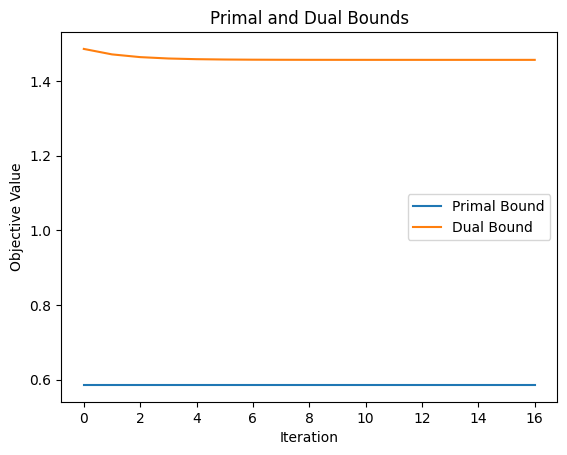

In [111]:
import matplotlib.pyplot as plt

primal_bounds = small_instances_primal_bounds[2][10]
dual_bounds = small_instances_dual_bounds[2][10]
# Plotting the primal and dual bounds
plt.plot(primal_bounds, label='Primal Bound')
plt.plot(dual_bounds, label='Dual Bound')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.legend()
plt.title('Primal and Dual Bounds')
plt.show()

### 4. Implementation and evaluation of models and algorithms

Test the proposed models, as well as the algorithms proposed by you on different instance sizes on the $m=100$ instances provided. The size of the instances is defined by the number of products:

- small: $n=10$ products
- medium: $n=5.000$ products

Each set of instances consists of 2 .csv files:

- size-mu.csv: A $(n+1) \times m$ matrix with $\mu_{i}$ values
- size-r.csv: A $(n+1) \times m$ matrix with $r_{i}$ values

You are also asked to test your models with a large instance of $n=1.000 .000$ products, which you should generate following the same structure as the data you were given. Assume:

$$
\mu_{0}=0 \quad r_{0}=0 \quad \mu_{i} \sim U[0,1] \quad r_{i} \sim U[0,1]
$$

When generating this instance you should either save the values in a .csv file like the one we give you, or set the random number generator seed so as not to produce different instances each time you run your code. For each instance size and each model/algorithm, report the minimum, average and maximum optimal values, as well as the minimum, maximum and average solution times.

### 5. Conclusion

TODO